### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [80]:
import numpy as np
import pandas as pd

data = pd.read_csv('processed_data_with_new_features.csv', index_col='id')

In [58]:
data['log_trip_duration']

id
id2875421    6.122493
id2377394    6.498282
id3858529    7.661527
id3504673    6.063785
id2181028    6.077642
               ...   
id2376096    6.658011
id1049543    6.486161
id2304944    6.639876
id2714485    5.924256
id1209952    5.293305
Name: log_trip_duration, Length: 1458644, dtype: float64

Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [81]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных

data[['passenger_count', 'distance_km']].isna().sum()

passenger_count    145864
distance_km        145864
dtype: int64

Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [82]:
### Your code is here
most_popular_pass_count = data['passenger_count'].value_counts().max()
data['passenger_count'] = data['passenger_count'].fillna(most_popular_pass_count)

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [83]:
### Your code is here
columns_for_grop = 'vendor_id store_and_fwd_flag traffic_jam month_2 month_3 month_4 month_5 month_6'.split(' ')
first_nan_loc = data.loc['id3858529'][columns_for_grop].to_list()
print(data.groupby(columns_for_grop)['distance_km'].mean().loc[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
grouped_means = data.groupby(columns_for_grop)['distance_km'].transform('mean')
data['distance_km'] = data['distance_km'].fillna(grouped_means)

3.183494170366727


In [56]:
### Убедимся, что пропусков не осталось

### Your code is here
data.isna().sum().sum()

0

### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [60]:
X = data.drop('log_trip_duration', axis =1)
y = data['log_trip_duration']

In [61]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

model = LinearRegression()
c_v = cross_validate(model, X,y, cv = 4, scoring='neg_mean_squared_error')
cross_val_error = pd.DataFrame(c_v).mean()
print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: fit_time      3.918
score_time    0.263
test_score   -0.432
dtype: float64


### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
### Your code is here


<AxesSubplot:xlabel='log_trip_duration'>

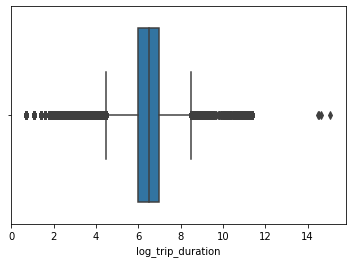

In [84]:
sns.boxplot(data = data, x = 'log_trip_duration')

Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [89]:
ma, mi = data['log_trip_duration'].quantile([0.995,0.005])
data_out_outliers = data[(data['log_trip_duration'] > mi) & (data['log_trip_duration'] < ma)]

In [87]:
### Your code is here
np.percentile(data['log_trip_duration'], [99.5, 0.5])


array([8.32845107, 3.93182563])

Снова замерьте качество на кросс-валидации, используя старый selector

In [90]:
### Your code is here
X = data_out_outliers.drop('log_trip_duration', axis =1)
y = data_out_outliers['log_trip_duration']

In [94]:
model = LinearRegression()
c_v = cross_validate(model, X,y, cv = 4, scoring='neg_root_mean_squared_error')
cross_val_error = pd.DataFrame(c_v).mean()
print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: fit_time      3.998
score_time    0.249
test_score   -0.584
dtype: float64
